In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from  sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
mydata=pd.read_excel('C:/Users/Lenovo/Downloads/CaseStudy/Predicting credit card spend/Data Set.xlsx')
mydata

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3675-GZFGOT-QJN,2,2.0,0,68,6,January,10,1,1,...,1,0,0,0,0,0,1,0,0,0
4996,4699-LEPCCE-3UD,3,3.0,0,51,5,May,14,2,1,...,1,0,0,0,0,0,0,0,0,0
4997,8485-LLUICH-CVV,4,5.0,0,75,6,August,17,4,1,...,1,1,0,0,0,0,1,0,0,0
4998,9325-URAAUT-7FA,1,1.0,0,47,4,December,19,4,2,...,1,0,1,1,1,0,1,0,0,0


In [3]:
mydata['total_spend']=mydata.cardspent + mydata.card2spent

In [4]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 131 entries, custid to total_spend
dtypes: float64(32), int64(97), object(2)
memory usage: 5.0+ MB


In [5]:
def continuous_var_summary(x):
    return pd.Series([x.dtype, x.nunique(), x.count(), x.isnull().sum(), x.sum(), x.mean(),
                      x.median(), x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
            index = ['DataType', 'C', 'N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                           'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.nunique(), x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['C', 'N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
contivars=mydata.select_dtypes(['float64','int64'])
contivars.apply(continuous_var_summary).T

,DataType,C,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
region,int64,5,5000,0,15007,3.0014,3,1.42176,2.0214,1,1,1,1,2,3,4,5,5,5,5
townsize,float64,5,4998,2,13431,2.68727,3,1.42592,2.03326,1,1,1,1,1,3,4,5,5,5,5
gender,int64,2,5000,0,2518,0.5036,1,0.500037,0.250037,0,0,0,0,0,1,1,1,1,1,1
age,int64,62,5000,0,235128,47.0256,47,17.7703,315.785,18,18,20,23,31,47,62,72,76,79,79
agecat,int64,5,5000,0,21194,4.2388,4,1.30878,1.71292,2,2,2,2,3,4,5,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
news,int64,2,5000,0,2363,0.4726,0,0.499299,0.249299,0,0,0,0,0,0,1,1,1,1,1
response_01,int64,2,5000,0,418,0.0836,0,0.276815,0.0766264,0,0,0,0,0,0,0,0,1,1,1
response_02,int64,2,5000,0,649,0.1298,0,0.336117,0.112975,0,0,0,0,0,0,0,1,1,1,1
response_03,int64,2,5000,0,513,0.1026,0,0.303466,0.0920917,0,0,0,0,0,0,0,1,1,1,1


In [7]:
mydata.drop(columns=['custid','agecat','edcat','empcat','birthmonth','income','inccat','creddebt','othdebt','spousedcat','addresscat','carcatvalue','commutecat','longmon','longten','lntollmon','lnequipmon','lntollten','lnequipten','lncardmon','lncardten','lnwiremon','lnwireten','cardspent','card2spent'],inplace=True)

In [8]:
mydata.drop(columns=['card2tenurecat'],inplace=True)

In [9]:
contivars=mydata.select_dtypes(['float64','int64'])
contivars.apply(continuous_var_summary).T[:110]

,DataType,C,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
region,int64,5,5000,0,15007,3.0014,3,1.42176,2.0214,1,1,1,1,2,3,4,5,5,5,5
townsize,float64,5,4998,2,13431,2.68727,3,1.42592,2.03326,1,1,1,1,1,3,4,5,5,5,5
gender,int64,2,5000,0,2518,0.5036,1,0.500037,0.250037,0,0,0,0,0,1,1,1,1,1,1
age,int64,62,5000,0,235128,47.0256,47,17.7703,315.785,18,18,20,23,31,47,62,72,76,79,79
ed,int64,18,5000,0,72715,14.543,14,3.28108,10.7655,6,8,9,10,12,14,17,19,20,21,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
news,int64,2,5000,0,2363,0.4726,0,0.499299,0.249299,0,0,0,0,0,0,1,1,1,1,1
response_01,int64,2,5000,0,418,0.0836,0,0.276815,0.0766264,0,0,0,0,0,0,0,0,1,1,1
response_02,int64,2,5000,0,649,0.1298,0,0.336117,0.112975,0,0,0,0,0,0,0,1,1,1,1
response_03,int64,2,5000,0,513,0.1026,0,0.303466,0.0920917,0,0,0,0,0,0,0,1,1,1,1


In [47]:
catvars=mydata.loc[:,['region','townsize','gender','jobcat','retire','homeown','hometype','carown','cartype','carbought','carbuy','commutecar','commutemotorcycle','commutebus','commuterail','commutepublic','commutebike','commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit','cardfee','card2','card2type','card2benefit','card2fee','active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02','response_03']]

In [49]:
cat_var_d=pd.get_dummies(catvars.astype('category'))

In [50]:
cat_var_d

,region_1,region_2,region_3,region_4,region_5,townsize_1.0,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,...,ownfax_0,ownfax_1,news_0,news_1,response_01_0,response_01_1,response_02_0,response_02_1,response_03_0,response_03_1
0,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,1,0,0,1,1,0
1,0,0,0,0,1,0,0,0,0,1,...,0,1,0,1,1,0,1,0,1,0
2,0,0,1,0,0,0,0,0,1,0,...,1,0,0,1,1,0,1,0,1,0
3,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,1,1,0,1,0
4,0,1,0,0,0,0,1,0,0,0,...,1,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,1,0,0,0,0,1,0,0,0,...,1,0,0,1,1,0,1,0,1,0
4996,0,0,1,0,0,0,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
4997,0,0,0,1,0,0,0,0,0,1,...,1,0,0,1,1,0,1,0,1,0
4998,1,0,0,0,0,1,0,0,0,0,...,1,0,0,1,1,0,1,0,1,0


In [53]:
num_var = mydata[mydata.columns.difference(['region','townsize','gender','jobcat','retire','homeown','hometype','carown','cartype','carbought','carbuy','commutecar','commutemotorcycle','commutebus','commuterail','commutepublic','commutebike','commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit','cardfee','card2','card2type','card2benefit','card2fee','active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02','response_03'])]

In [54]:
num_var

,address,age,card2tenure,cardmon,cardten,cardtenure,cardtenurecat,cars,carvalue,commute,...,pets_small,reside,spoused,tenure,tollmon,tollten,total_spend,union,wiremon,wireten
0,0,20,3,14.25,60.0,2,2,2,14.3,8,...,0,3,-1,5,29.0,161.05,149.46,1,0.00,0.00
1,2,22,4,16.00,610.0,4,2,2,6.8,1,...,0,2,-1,39,0.0,0.00,77.54,0,45.65,1683.55
2,30,67,25,23.00,1410.0,35,5,3,18.8,4,...,0,3,13,65,0.0,0.00,359.97,0,0.00,0.00
3,3,23,5,21.00,685.0,5,2,3,8.7,1,...,0,5,18,36,0.0,0.00,359.41,0,0.00,0.00
4,3,26,9,17.25,360.0,8,3,1,10.6,6,...,0,4,13,21,16.5,387.70,507.83,0,19.05,410.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,24,68,28,21.75,1565.0,35,5,1,64.5,5,...,0,1,-1,69,0.0,0.00,1425.67,0,0.00,0.00
4996,12,51,13,26.25,800.0,15,4,2,40.0,4,...,0,1,-1,30,36.5,1157.20,366.35,0,27.90,757.35
4997,48,75,29,15.25,1070.0,40,5,3,53.6,1,...,0,1,-1,72,44.0,3322.50,1527.75,0,0.00,0.00
4998,16,47,15,9.50,345.0,22,5,2,96.0,1,...,0,4,15,37,0.0,0.00,752.95,0,0.00,0.00


In [55]:
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [56]:
num_var=num_var.apply(missing_imputation)

In [57]:
##outlier treatment
num_var = num_var.apply(lambda x: x.clip(lower = x.quantile(0.01), 
                                                         upper = x.quantile(0.99)))

In [58]:
cat_var_d =cat_var_d.apply(missing_imputation)

In [59]:
df=pd.concat([num_var,cat_var_d],axis=1)

### Assumption Check 

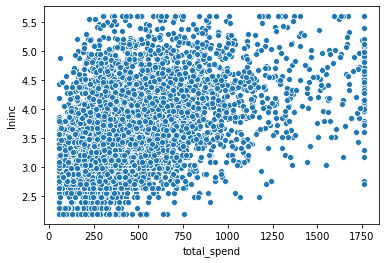

In [61]:
sns.scatterplot(df.total_spend,df.lninc)
plt.show()

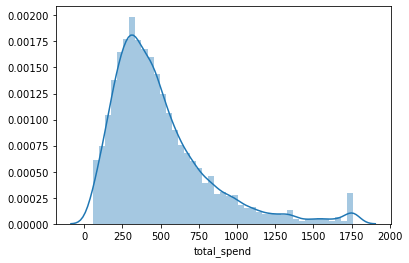

In [62]:

sns.distplot(df.total_spend)
plt.show()

In [63]:
df.total_spend.skew()

1.615173337243418

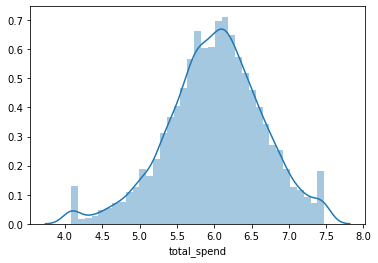

In [64]:
sns.distplot(np.log(df.total_spend + 1 ))

In [65]:
np.log(df.total_spend + 1 ).skew()

-0.29228103881126855

In [66]:
df['ln_total_spend']=np.log(df.total_spend + 1 )

In [67]:
features=df.columns.difference(['ln_total_spend','total_spend']).to_list()

In [68]:
f_val,p_val =f_regression(df[features],df['ln_total_spend'])

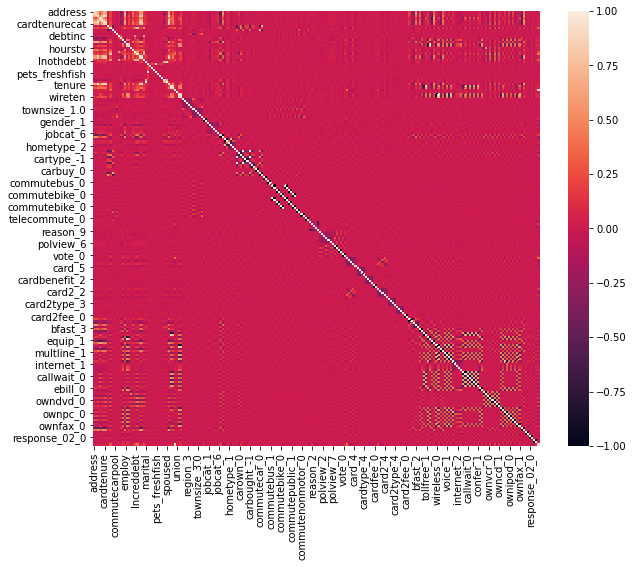

In [69]:
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr())

In [70]:
df[features]

,active_0,active_1,address,age,bfast_1,bfast_2,bfast_3,callcard_0,callcard_1,callid_0,...,townsize_5.0,union,voice_0,voice_1,vote_0,vote_1,wireless_0,wireless_1,wiremon,wireten
0,1,0,0,20,0,0,1,0,1,1,...,0,1,0,1,0,1,1,0,0.00,0.00
1,0,1,2,22,1,0,0,0,1,0,...,1,0,0,1,1,0,0,1,45.65,1683.55
2,1,0,30,67,0,0,1,0,1,1,...,0,0,1,0,1,0,1,0,0.00,0.00
3,0,1,3,23,1,0,0,0,1,1,...,0,0,1,0,1,0,1,0,0.00,0.00
4,0,1,3,26,0,0,1,0,1,0,...,0,0,0,1,1,0,0,1,19.05,410.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,0,24,68,0,1,0,0,1,1,...,0,0,1,0,0,1,1,0,0.00,0.00
4996,0,1,12,51,1,0,0,0,1,0,...,0,0,1,0,1,0,0,1,27.90,757.35
4997,1,0,48,75,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0.00,0.00
4998,1,0,16,47,0,0,1,0,1,1,...,0,0,1,0,1,0,1,0,0.00,0.00


In [71]:
f_reg =pd.concat([pd.Series(df[features].columns),pd.Series(f_val),pd.Series(p_val)],axis=1)

In [72]:
f_reg.columns=['Columns','f_val','p_val']

In [73]:
imp_var=f_reg.loc[f_reg.p_val < 0.01,['Columns']]

In [74]:
imp_var=imp_var.iloc[:,0].to_list()

In [75]:
len(imp_var)

94

In [76]:
model_param = 'ln_total_spend ~ ' + ' + '.join(imp_var)

In [77]:
model_param

'ln_total_spend ~ address + bfast_2 + bfast_3 + callid_0 + callid_1 + callwait_0 + callwait_1 + card2_1 + card2_2 + card2_3 + card2_4 + card2_5 + card2tenure + card_1 + card_2 + card_3 + card_4 + card_5 + cardtenure + cardtenurecat + carown_0 + carown_1 + carvalue + confer_0 + confer_1 + ed + employ + equip_0 + equip_1 + equipmon + equipten + forward_0 + forward_1 + gender_0 + gender_1 + homeown_0 + homeown_1 + hometype_1 + hometype_2 + hourstv + internet_0 + internet_3 + internet_4 + jobcat_1 + jobcat_2 + jobcat_3 + jobsat + lncreddebt + lninc + lnlongmon + lnlongten + lnothdebt + multline_0 + multline_1 + owncd_0 + owncd_1 + owndvd_0 + owndvd_1 + ownfax_0 + ownfax_1 + owngame_0 + owngame_1 + ownipod_0 + ownipod_1 + ownpc_0 + ownpc_1 + ownpda_0 + ownpda_1 + owntv_0 + owntv_1 + ownvcr_0 + ownvcr_1 + pager_0 + pager_1 + reason_1 + reason_2 + reason_4 + response_03_0 + response_03_1 + retire_0 + retire_1 + tenure + tollfree_0 + tollfree_1 + tollmon + tollten + voice_0 + voice_1 + vote_0 

In [190]:
y, X = dmatrices(model_param, df, return_type = 'dataframe')
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['vif_factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values(by=['vif_factor'],ascending=False).reset_index()

,index,Features,vif_factor
0,0,Intercept,117.409803
1,23,lninc,2.184129
2,10,ed,1.596706
3,30,ownpc_1,1.570268
4,11,equipten,1.544684
5,32,ownvcr_0,1.542215
6,22,lncreddebt,1.526655
7,1,bfast_2,1.522223
8,37,tollten,1.511106
9,5,card2_4,1.497064


In [191]:
## removing variables having high vif one by one
model_param ='ln_total_spend ~ bfast_2 + bfast_3  + card2_1 + card2_2 +  card2_4 + card_1 +  card_3  + card_5 + carown_1+ ed + equipten + forward_0 +  gender_0 +   homeown_1 + hometype_1 +  hourstv + internet_3 + internet_4 + jobcat_1 + jobcat_3 + jobsat + lncreddebt + lninc  + multline_0 + owncd_0 +  owndvd_1 + ownfax_1 +  owngame_1 +  ownipod_1 +  ownpc_1 +  ownpda_1 + ownvcr_0 + reason_1 + reason_2 + reason_4 + response_03_0 +tollten +  vote_1 '

In [192]:
train,test = train_test_split(df,test_size=0.3,random_state=0)

In [272]:
ln=smf.ols(model_param,data=train)
ln=ln.fit()

In [273]:
ln.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_total_spend   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     137.2
Date:                Tue, 24 Nov 2020   Prob (F-statistic):          9.85e-301
Time:                        17:32:42   Log-Likelihood:                -2718.0
No. Observations:                3500   AIC:                             5464.
Df Residuals:                    3486   BIC:                             5550.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7704      0.058     82.294      0.000       4.657       4.884
bfast_2       -0.0425      0.019     -2.198      0.028      -0.080      -0.005
card2_1        0.3396      0.027     12.456      0.000       0.286       0.393
card2_2       -0.0465      0.023     -2.010      0.044      -0.092      -0.001
card2_4       -0.0524      0.025     -2.099      0.036      -0.101      -0.003
card_1         0.5971      0.024     24.397      0.000       0.549       0.645
ed            -0.0131      0.003     -4.297      0.000      -0.019      -0.007
gender_0       0.0601      0.018      3.350      0.001       0.025       0.095
internet_3     0.0639      0.029      2.233      0.026       0.008       0.120
internet_4     0.0799      0.030      2.669      0.008       0.021       0.139
lninc          0.3337      0.012     27.037      0.000       0.309       0.358
reason_1      -0.0985      0.031     -3.151      0.002      -0.160      -0.037
reason_2       0.2676      0.036      7.419      0.000       0.197       0.338
reason_4      -0.1501      0.061     -2.446      0.014      -0.270      -0.030
==============================================================================
Omnibus:                       75.492   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.920
Skew:                          -0.348   Prob(JB):                     2.68e-18
Kurtosis:                       3.267   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [472]:
## removing variables having high p_val from summary one by one

In [271]:
model_param ='ln_total_spend ~ bfast_2 + card2_1 + card2_2 +  card2_4 + card_1  + ed +  gender_0 + internet_3 + internet_4  +lninc  +  reason_1 + reason_2 + reason_4'


In [274]:
train_pred = pd.DataFrame({'actual':np.exp(train.ln_total_spend),'pred':np.exp(ln.predict(train))})

In [275]:
train_pred

,actual,pred
2858,329.7100,370.114220
1559,1091.9600,388.944322
1441,360.9900,390.691869
2179,731.1300,803.395767
1390,59.1976,282.645523
...,...,...
4931,270.5000,307.187497
3264,392.2600,368.674732
1653,761.5400,790.066107
2607,177.3400,276.363854


In [276]:
test_pred = pd.DataFrame({'actual':np.exp(test.ln_total_spend),'pred':np.exp(ln.predict(test))})

In [277]:
test_pred

,actual,pred
398,635.19,759.329766
3833,534.59,410.799360
4836,310.45,558.857264
4572,1226.08,355.773046
636,557.65,367.163268
...,...,...
4554,194.92,301.401639
4807,476.40,415.209138
1073,622.17,378.938313
2906,459.41,697.933004


In [278]:
MAE_train = mean_absolute_error(train_pred.actual, train_pred.pred)
MAE_test = mean_absolute_error(test_pred.actual, test_pred.pred)

# print the values of MAE for train and test
print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  186.5384403407128  |  MAE of testing data:  189.84573934511752


In [279]:
MSE_train = mean_squared_error(train_pred.actual, train_pred.pred)
MSE_test = mean_squared_error(test_pred.actual, test_pred.pred)

# print the values of MSE for train and test
print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)

# print the values of RMSE for train and test
print('RMSE of training data: ', np.sqrt(MSE_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_test))

MSE of training data:  71275.56054245961  |  MSE of testing data:  73257.57743693692
RMSE of training data:  266.97483129025403  |  RMSE of testing data:  270.66137041871514


### Assumption Check  
##assumption: Normality of the residuals/error (using distplot)

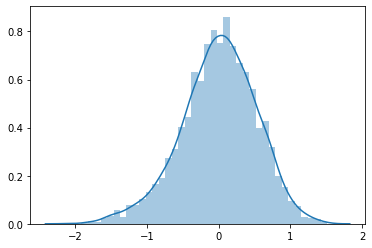

In [280]:
sns.distplot(ln.resid)

In [281]:
ln.resid.skew()

-0.3479279041776584

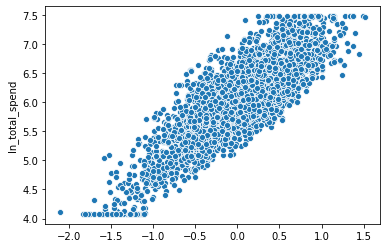

In [282]:
# assumption: homoscedasticity of residuals/errors
sns.scatterplot(ln.resid,df.ln_total_spend)
plt.show()

In [283]:
train_pred.loc[:, 'Deciles'] = pd.qcut( train_pred.pred, 10, labels = False )
test_pred.loc[:, 'Deciles'] = pd.qcut( test_pred.pred, 10, labels = False )

# Decile Analysis for train data
Predicted_avg_train = train_pred.groupby('Deciles')[['actual', 'pred']].mean().reset_index().sort_index(ascending = False)
Predicted_avg_test = test_pred.groupby('Deciles')[['actual', 'pred']].mean().reset_index().sort_index(ascending = False)

In [284]:
Predicted_avg_train 

,Deciles,actual,pred
9,9,908.870472,833.944563
8,8,701.961441,617.328556
7,7,559.882192,525.017098
6,6,526.872056,460.965436
5,5,473.301835,408.787082
4,4,433.288001,366.203543
3,3,384.559329,331.352594
2,2,348.229258,302.700974
1,1,311.119695,273.716954
0,0,271.052271,231.321701


In [285]:
Predicted_avg_test

,Deciles,actual,pred
9,9,900.538813,844.277698
8,8,724.783747,624.436898
7,7,629.936699,527.261133
6,6,516.761467,458.655598
5,5,489.172867,411.103574
4,4,412.307584,372.522055
3,3,364.700317,337.350764
2,2,368.354800,304.398317
1,1,330.589435,273.906652
0,0,266.045187,229.742823


In [ ]:
## Therefore key drivers affecting spend are ~ bfast_2  + card2_1 + card2_2 +  card2_4 + card_1  + ed +  gender_0 + 
## internet_3 + internet_4  +lninc  +  reason_1 + reason_2 + reason_4'

# Random Forest 

In [286]:
df

,address,age,card2tenure,cardmon,cardten,cardtenure,cardtenurecat,cars,carvalue,commute,...,ownfax_1,news_0,news_1,response_01_0,response_01_1,response_02_0,response_02_1,response_03_0,response_03_1,ln_total_spend
0,0,20,3,14.25,60.0,2,2,2,14.300,8,...,0,1,0,1,0,0,1,1,0,5.013697
1,2,22,4,16.00,610.0,4,2,2,6.800,1,...,1,0,1,1,0,1,0,1,0,4.363608
2,30,67,25,23.00,1410.0,35,5,3,18.800,4,...,0,0,1,1,0,1,0,1,0,5.888795
3,3,23,5,21.00,685.0,5,2,3,8.700,1,...,0,0,1,0,1,1,0,1,0,5.887242
4,3,26,9,17.25,360.0,8,3,1,10.600,6,...,0,1,0,1,0,0,1,1,0,6.232114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,24,68,28,21.75,1565.0,35,5,1,64.500,5,...,0,0,1,1,0,1,0,1,0,7.263098
4996,12,51,13,26.25,800.0,15,4,2,40.000,4,...,0,1,0,1,0,1,0,1,0,5.906315
4997,48,75,29,15.25,1070.0,40,5,3,53.600,1,...,0,0,1,1,0,1,0,1,0,7.332206
4998,16,47,15,9.50,345.0,22,5,2,92.001,1,...,0,0,1,1,0,1,0,1,0,6.625326


In [287]:
trainx,testx,trainy,testy = train_test_split(df[df.columns.difference(['ln_total_spend','total_spend'])],df['ln_total_spend'],test_size=0.3,random_state=123)

In [ ]:
RandomForestRegressor()

In [ ]:
## param_grid={'n_estimators':[100,200,300,400,500],'max_depth =np.arange(5,30)'}
#gs=GridSearchCV(RandomForestRegressor(),param_grid,cv=5,n_jobs=-1)
#gs.fit(trainx,trainy)

In [36]:
param_grid={'n_estimators':[100,200,300,400,500],
           }
gs=GridSearchCV(RandomForestRegressor(),param_grid,cv=5,n_jobs=-1)
gs.fit(trainx,trainy)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300, 400, 500]})

In [37]:
gs.best_params_

{'n_estimators': 400}

In [44]:
gs.score(trainx,trainy)

0.9054798508171129

In [288]:
rf = RandomForestRegressor(400,random_state=123)
rf.fit(trainx,trainy)

RandomForestRegressor(n_estimators=400, random_state=123)

In [289]:
rf.score(trainx,trainy)

0.9057096267817369

In [292]:
train_pred = pd.DataFrame({'actual':np.exp(trainy),'pred':np.exp(rf.predict(trainx))})

In [293]:
train_pred

,actual,pred
4036,669.1400,688.787101
2883,182.8300,223.227017
4162,220.5400,242.811639
4640,501.0100,447.969692
2430,1761.1024,1036.311714
...,...,...
1593,208.1900,235.742496
4060,178.0100,239.476802
1346,568.8700,454.995519
3454,303.9500,319.715948


In [294]:
test_pred = pd.DataFrame({'actual':np.exp(testy),'pred':np.exp(rf.predict(testx))})

In [295]:
test_pred

,actual,pred
2648,326.49,267.769946
2456,516.02,395.881659
4557,562.52,369.618902
4884,484.45,258.120410
92,491.75,450.283368
...,...,...
3014,404.05,652.145052
734,120.53,300.595305
452,217.28,358.610480
2558,355.14,417.057278


In [296]:
MAE_train = mean_absolute_error(train_pred.actual, train_pred.pred)
MAE_test = mean_absolute_error(test_pred.actual, test_pred.pred)

# print the values of MAE for train and test
print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  76.57328657905109  |  MAE of testing data:  191.78402523282026


In [297]:
MSE_train = mean_squared_error(train_pred.actual, train_pred.pred)
MSE_test = mean_squared_error(test_pred.actual, test_pred.pred)

# print the values of MSE for train and test
print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)

# print the values of RMSE for train and test
print('RMSE of training data: ', np.sqrt(MSE_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_test))

MSE of training data:  14878.730178466758  |  MSE of testing data:  75434.23886617406
RMSE of training data:  121.97840045871547  |  RMSE of testing data:  274.65294257694393


In [298]:
train_pred.loc[:, 'Deciles'] = pd.qcut( train_pred.pred, 10, labels = False )
test_pred.loc[:, 'Deciles'] = pd.qcut( test_pred.pred, 10, labels = False )

# Decile Analysis for train data
Predicted_avg_train = train_pred.groupby('Deciles')[['actual', 'pred']].mean().reset_index().sort_index(ascending = False)
Predicted_avg_test = test_pred.groupby('Deciles')[['actual', 'pred']].mean().reset_index().sort_index(ascending = False)

In [299]:
Predicted_avg_train

,Deciles,actual,pred
9,9,1214.417897,990.527272
8,8,776.735257,680.609267
7,7,620.214514,560.787068
6,6,515.456629,482.122720
5,5,454.885800,425.093247
4,4,386.157400,374.389657
3,3,329.121971,332.054333
2,2,274.076657,290.272202
1,1,218.927400,241.720506
0,0,128.210790,165.578019


In [300]:
Predicted_avg_test

,Deciles,actual,pred
9,9,836.021728,819.015426
8,8,669.000413,624.862903
7,7,610.409067,526.965187
6,6,581.752683,456.326152
5,5,473.211067,411.542874
4,4,460.945683,370.028092
3,3,392.697317,329.326901
2,2,353.649069,304.786881
1,1,329.201717,283.005300
0,0,298.477387,229.140286


In [307]:
list(zip(trainx.columns,rf.feature_importances_))

[('active_0', 0.0016069951296289122),
 ('active_1', 0.001616646580001029),
 ('address', 0.015379193745049433),
 ('age', 0.015923114541079555),
 ('bfast_1', 0.002027510576056071),
 ('bfast_2', 0.0018598409261920347),
 ('bfast_3', 0.002174917308731717),
 ('callcard_0', 0.0005333532969737182),
 ('callcard_1', 0.00040484103101956584),
 ('callid_0', 0.0011271509824148083),
 ('callid_1', 0.0011142731955291487),
 ('callwait_0', 0.0009752341886636875),
 ('callwait_1', 0.0010745370741559153),
 ('carbought_-1', 0.0002270312340703677),
 ('carbought_0', 0.0018851881164207987),
 ('carbought_1', 0.001715617587823982),
 ('carbuy_0', 0.0017028206659933614),
 ('carbuy_1', 0.001694631329507533),
 ('card2_1', 0.043362537144845364),
 ('card2_2', 0.0029084551329695545),
 ('card2_3', 0.0019072996193507789),
 ('card2_4', 0.0014802110257012436),
 ('card2_5', 0.002451441638667923),
 ('card2benefit_1', 0.0022873197051409833),
 ('card2benefit_2', 0.002362478428024583),
 ('card2benefit_3', 0.002654076987780236),


In [309]:
ce=pd.DataFrame(rf.feature_importances_, trainx.columns)
ce.columns=['Coefficients']
ce.sort_values('Coefficients',ascending=False,inplace=True)
ce['Coefficients']=((ce['Coefficients'])*100).round(2)
ce=ce.head(10)

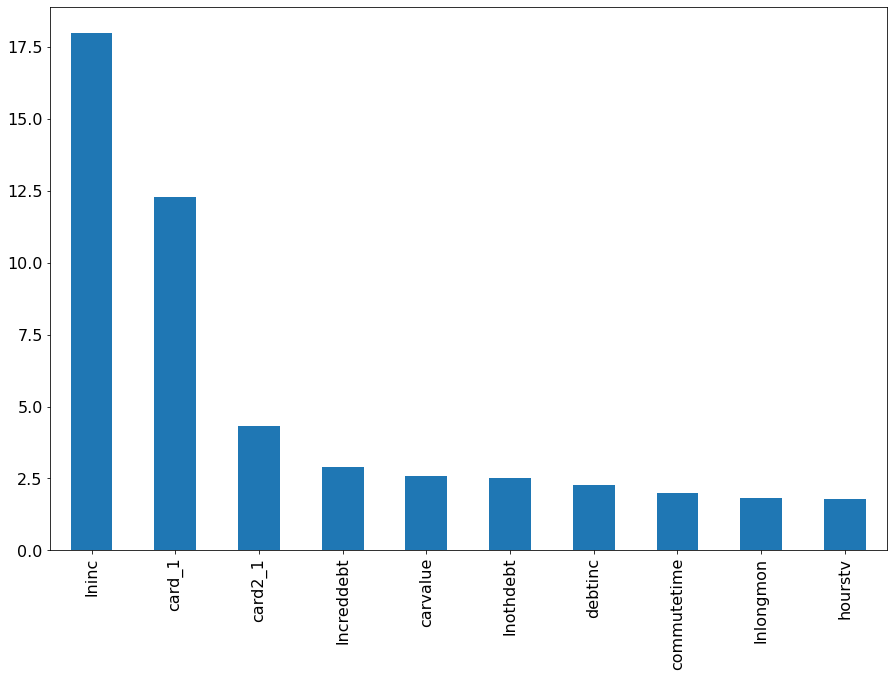

In [310]:
cece=ce.head(12)
ce.Coefficients.plot(kind='bar',figsize=(15,10),fontsize=16)
plt.show()
